Alternate Catalog Test 7: 

Version: **13 January 2025**

**Note:** Same as Alternate Catalog 4 (with no k-corrections), but fitting an ellipse in each apparent magnitude bin rather than a global ellipse.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c
from astropy.io import fits

from cosmoprimo.fiducial import DESI

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.stats import chi2

from tqdm import tqdm
from hdbscan import HDBSCAN
from scipy.stats import binned_statistic
from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '../'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_corr-20251030.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.5690596280100633e-05,122.32238811543634,10.869518800965125,N
55,SGA-2020 55,PGC1203

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = FlatLambdaCDM(H0=100, Om0=0.3151)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

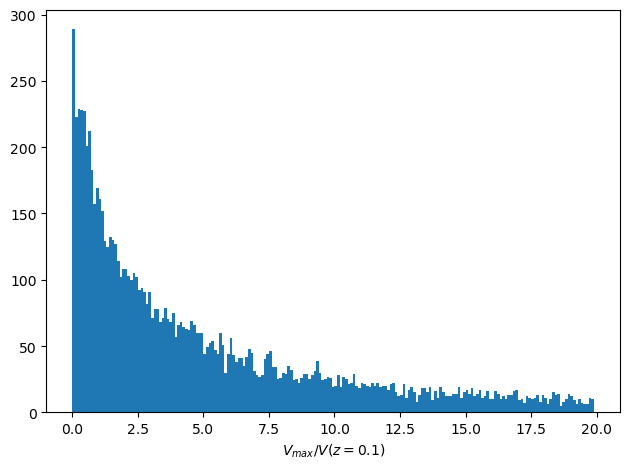

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [8]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '../'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [9]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [10]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [11]:
lucey_VIpath = '../VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [12]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [13]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.761488

# Photometric corrections

### Survey offsets

In [14]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [15]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [16]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [17]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [18]:
# ##### Split the data into 3 regions z<=0.03 to be corrected to z=0.03, z>=0.1 to be corrected to z=0.1,
# ##### and the middle region to have no k-correction

# zg0_low = (sgatab['Z_DESI'] >= 0) & (sgatab['Z_DESI'] <= 0.03) #there are a couple below zero
# zg0_high = (sgatab['Z_DESI'] >= 0.1)

# kcorr_zg0_low = k_corr(sgatab['Z_DESI'][zg0_low], 
#                    [sgatab['G_MAG_SB26'][zg0_low], sgatab['R_MAG_SB26'][zg0_low], sgatab['Z_MAG_SB26'][zg0_low]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0_low], sgatab['R_MAG_SB26_ERR'][zg0_low], sgatab['Z_MAG_SB26_ERR'][zg0_low]], 
#                    z_corr=0.03)

# kcorr_zg0_high = k_corr(sgatab['Z_DESI'][zg0_high], 
#                    [sgatab['G_MAG_SB26'][zg0_high], sgatab['R_MAG_SB26'][zg0_high], sgatab['Z_MAG_SB26'][zg0_high]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0_high], sgatab['R_MAG_SB26_ERR'][zg0_high], sgatab['Z_MAG_SB26_ERR'][zg0_high]], 
#                    z_corr=0.1)


# kcorr = np.zeros((len(sgatab), 3))
# kcorr[zg0_low] = kcorr_zg0_low
# kcorr[zg0_high] = kcorr_zg0_high

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [19]:
temp_infile = open('../iron_internalDust_z0p1_mcmc_nokcorr.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [20]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [21]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [22]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr - internalDust_corr_z

In [23]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [24]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax, dz)

zbin_indices = np.digitize(sgatab['Z_DESI_CMB'], zbins, right=True)

In [25]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  1955 galaxies
 1  0.030 < z <= 0.035  882 galaxies
 2  0.035 < z <= 0.040  714 galaxies
 3  0.040 < z <= 0.045  655 galaxies
 4  0.045 < z <= 0.050  644 galaxies
 5  0.050 < z <= 0.055  638 galaxies
 6  0.055 < z <= 0.060  574 galaxies
 7  0.060 < z <= 0.065  546 galaxies
 8  0.065 < z <= 0.070  532 galaxies
 9  0.070 < z <= 0.075  443 galaxies
10  0.075 < z <= 0.080  469 galaxies
11  0.080 < z <= 0.085  427 galaxies
12  0.085 < z <= 0.090  360 galaxies
13  0.090 < z <= 0.095  228 galaxies
14  0.095 < z <= 0.100  219 galaxies
15  z > 0.100  914 galaxies


In [26]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

219 882


# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not an outlier (based on ellipse fit shown below notebook)

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [27]:
sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

data = np.array([sgatab['R_ABSMAG_SB26'], np.log10(sgatab['V_0p4R26'])])


##generate HDBScan population for comparison

# clusterer = HDBSCAN(cluster_selection_epsilon=0.07)

# clusterer.fit(data.T)

# hdbscan_boolean = clusterer.labels_ != 11

In [28]:
def fit_ellipse(x,y):
    X = np.vstack([x, y]).T
    ee = EllipticEnvelope(contamination=0.05, random_state=0)
    ee.fit(X)
    return ee.location_, ee.covariance_

def plot_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    """
    Draw a confidence ellipse from mean and covariance.
    n_std=2 ~ 95% for 2D
    """
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

    width, height = 2 * n_std * np.sqrt(eigvals)

    ellipse = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        **kwargs
    )
    ax.add_patch(ellipse)

def ellipse_boolean(x,y,n_std):
    X = np.vstack([x, y]).T
    ee = EllipticEnvelope(contamination=0.05, random_state=0)
    ee.fit(X)

    mahal_sq = ee.mahalanobis(X)
    outlier_boolean = mahal_sq > n_std**2
    return outlier_boolean

## Fit an ellipse in each redshift bin

In [29]:
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)
# cosmo = DESI()

sgatab['MU_ZCMB'] = cosmo.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

In [30]:
sigma = 2.5
mu_x = []
mu_y = []
cov_xx = []
cov_xy = []
cov_yx = []
cov_yy = []
zrow = []
## fit the lowest bin in absolute magnitude space 
# zrow.append(0)
# x = np.log10(sgatab['V_0p4R26'][zbin_indices==0])
# y = sgatab['R_ABSMAG_SB26'][zbin_indices==0]
# ellipse_mean, ellipse_cov = fit_ellipse(x,y)
# print(ellipse_mean, ellipse_cov)
# mu_x.append(ellipse_mean[0])
# mu_y.append(ellipse_mean[1])
# cov_xx.append(ellipse_cov[0][0]) 
# cov_xy.append(ellipse_cov[0][1]) 
# cov_yx.append(ellipse_cov[1][0]) 
# cov_yy.append(ellipse_cov[1][1]) 


for i in range(1,len(zbins)):
    zrow.append(i)
    x = np.log10(sgatab['V_0p4R26'][zbin_indices==i])
    y = sgatab['R_MAG_SB26_CORR'][zbin_indices==i]

    ellipse_mean, ellipse_cov = fit_ellipse(x,y)
    print(ellipse_mean, ellipse_cov)
    mu_x.append(ellipse_mean[0])
    mu_y.append(ellipse_mean[1])
    cov_xx.append(ellipse_cov[0][0]) 
    cov_xy.append(ellipse_cov[0][1]) 
    cov_yx.append(ellipse_cov[1][0]) 
    cov_yy.append(ellipse_cov[1][1]) 

# ## fit the highest bin in absolute magnitude space 
# i=len(zbins)
# zrow.append(i)
# x = np.log10(sgatab['V_0p4R26'][zbin_indices==0])
# y = sgatab['R_ABSMAG_SB26'][zbin_indices==0]
# ellipse_mean, ellipse_cov = fit_ellipse(x,y)
# print(ellipse_mean, ellipse_cov)
# mu_x.append(ellipse_mean[0])
# mu_y.append(ellipse_mean[1])
# cov_xx.append(ellipse_cov[0][0]) 
# cov_xy.append(ellipse_cov[0][1]) 
# cov_yx.append(ellipse_cov[1][0]) 
# cov_yy.append(ellipse_cov[1][1]) 

[ 2.03794765 15.54219286] [[ 0.02639319 -0.11994438]
 [-0.11994438  0.75634485]]
[ 2.08194009 15.57216   ] [[ 0.01974332 -0.09054577]
 [-0.09054577  0.61569454]]
[ 2.10993919 15.56754044] [[ 0.0200948  -0.08666656]
 [-0.08666656  0.53278777]]
[ 2.12489883 15.71943184] [[ 0.01915566 -0.08340122]
 [-0.08340122  0.54201055]]
[ 2.15653507 15.73012738] [[ 0.01508875 -0.06637161]
 [-0.06637161  0.44445727]]
[ 2.18527952 15.74843663] [[ 0.01442127 -0.06529245]
 [-0.06529245  0.44061662]]
[ 2.18144579 15.95492099] [[ 0.01471573 -0.05988887]
 [-0.05988887  0.36589081]]
[ 2.20538275 15.93045656] [[ 0.01481442 -0.056133  ]
 [-0.056133    0.34421304]]
[ 2.21936443 15.98687808] [[ 0.01320285 -0.05018942]
 [-0.05018942  0.33210432]]
[ 2.24108859 15.99010076] [[ 0.01196365 -0.04346596]
 [-0.04346596  0.27033767]]
[ 2.25899297 16.02936402] [[ 0.01229307 -0.04066877]
 [-0.04066877  0.25088133]]
[ 2.26975872 16.03363068] [[ 0.00978823 -0.03396032]
 [-0.03396032  0.22187041]]
[ 2.27959812 16.19743197] [[

In [31]:
ellipse_params = Table([zrow, mu_x, mu_y, cov_xx, cov_xy, cov_yx, cov_yy],
    names=['zrow','MU_X', 'MU_Y', 'COV_XX', 'COV_XY', 'COV_YX', 'COV_YY'])

In [230]:
# ellipse_params.write('TF_Y1_v7_ellipse_fit_mr_params.fits', overwrite=True)

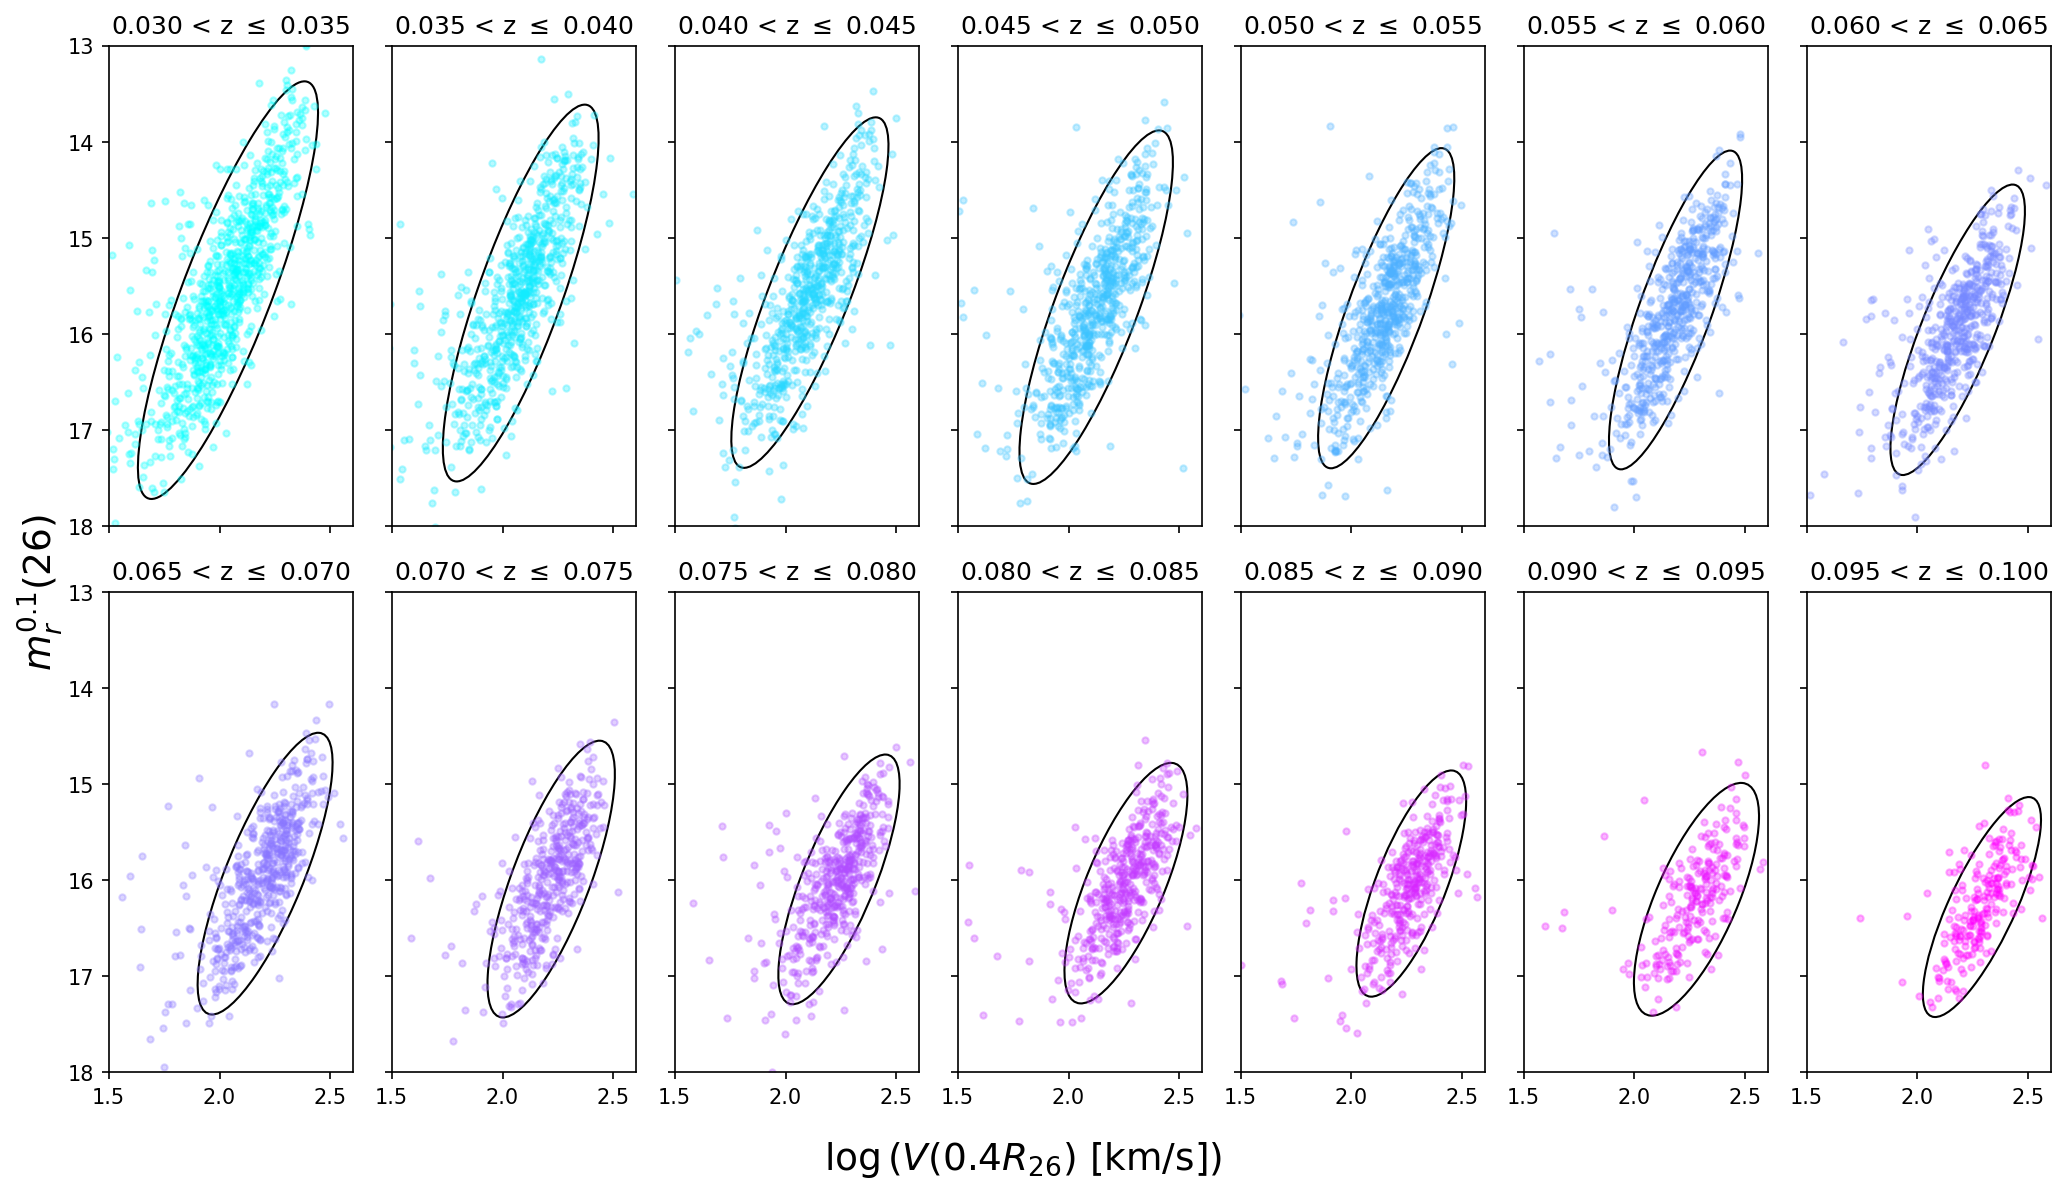

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=7, sharex=True, sharey=True, figsize=(14,8), tight_layout=True,
                        facecolor='none', dpi=150)
# fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)
m = len(mu_x)
color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/7)
    col = i%7
    
    eb = axs[row,col].errorbar(np.log10(sgatab['V_0p4R26'][zbin_indices==i+1]),#+1], 
                               sgatab['R_MAG_SB26_CORR'][zbin_indices==i+1],#+1], 
                               # xerr=sgatab['V_0p4R26_ERR'][zbin_indices==i],#+1], 
                               # yerr=sgatab['R_MAG_SB26_ERR_CORR'][zbin_indices==i],#+1], 
                               fmt='.', color=c, ecolor='lightgray', alpha=0.3)
    # axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    plot_ellipse(mean=(mu_x[i], mu_y[i]), cov = ([cov_xx[i], cov_xy[i]],[cov_yx[i], cov_yy[i]]),
                 n_std = sigma, ax=axs[row,col], edgecolor='k', facecolor='none')

    
    axs[row,col].set(xlim=[1.5, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {(zbins[i+1] if i+2 < len(zbins) else zmax):.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=18)
fig.supylabel(r'$m_r^{0.1} (26)$', fontsize=18);

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')


In [33]:
outlier_boolean = np.zeros(len(sgatab), dtype=bool)

## do the lowest and highest bins separately since they are in absmag space
bin_mask = (zbin_indices == 0)
x = np.log10(sgatab['V_0p4R26'][bin_mask])
y = sgatab['R_ABSMAG_SB26'][bin_mask]
outlier_bin = ellipse_boolean(x, y, sigma)
outlier_boolean[bin_mask] = outlier_bin

for i in range(1,len(zbins)):
    bin_mask = (zbin_indices == i)

    x = np.log10(sgatab['V_0p4R26'][bin_mask])
    y = sgatab['R_MAG_SB26_CORR'][bin_mask]

    # Outliers *within this bin*
    outlier_bin = ellipse_boolean(x, y, sigma)

    # Write results back into global array
    outlier_boolean[bin_mask] = outlier_bin

bin_mask = (zbin_indices == len(zbins))
x = np.log10(sgatab['V_0p4R26'][bin_mask])
y = sgatab['R_ABSMAG_SB26'][bin_mask]
outlier_bin = ellipse_boolean(x, y, sigma)
outlier_boolean[bin_mask] = outlier_bin

print(np.sum(outlier_boolean)/len(outlier_boolean))

0.12480392156862745


In [34]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~outlier_boolean

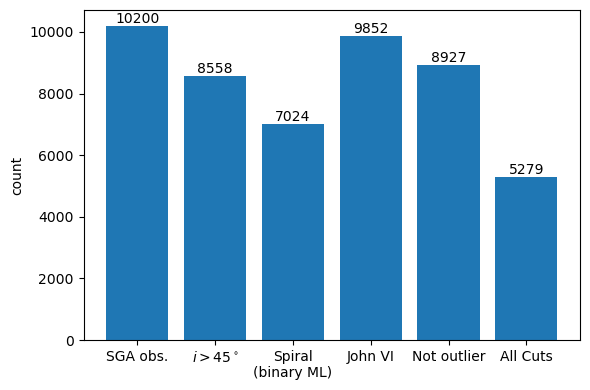

In [35]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    # 'Not dwarf' : np.sum(~dwarf_boolean), 
    'Not outlier' : np.sum(~outlier_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

In [36]:
sgatab_sel = sgatab[is_good_sga]
zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

# Build the Calibration Table of SGA Galaxies

In [37]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
11,0.08162327483927467,38.0,16.908297746704516,0.11122507294232536,122.32238811543634,10.869518800965125
13,0.09120074612338591,117.0,16.069547029314563,0.11457487276780005,180.65572517100514,13.281536295531684
4,0.04770393135250317,1158.0,14.982502191197128,0.109690690518275,177.6605660298364,10.878704878309893
6,0.05517343391109497,1358.0,14.665805288894662,0.06616048636630542,199.70906692232123,6.994075041243547
7,0.06211147463081468,1548.0,16.590887647230737,0.09790587339599037,169.13249088380044,11.414839425129315
6,0.05541189869150731,1663.0,16.445596950643232,0.13703041235780347,140.65284037083947,10.67103269233122
10,0.07868601783175921,1849.0,15.33591944694519,0.07291888706342384,224.5875972323314,8.330015749448037
4,0.048805933559745496,1996.0,16.822197931903972,0.09047307906106294,125.94703384316176,12.63905939086584
14,0.09620790749304664,2308.0,16.486920815549418,0.07955380018178793,149.56137968934948,13.205171425767093


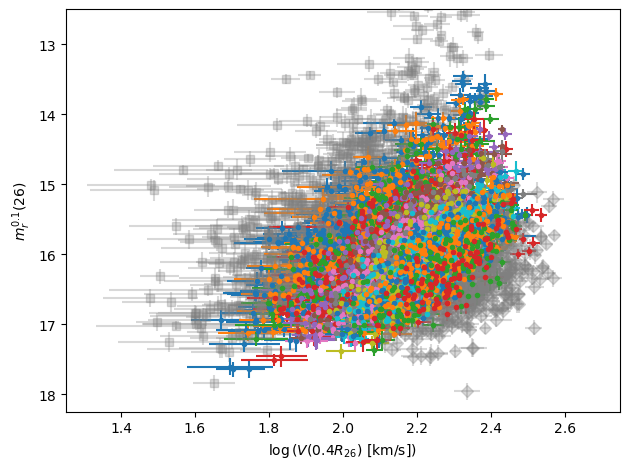

In [38]:
# fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
fig, axes = plt.subplots(1, 1, tight_layout=True)

logV0 = 0

# ax = axes[0] 
ax = axes

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18.25, 12.5],
       ylabel=r'$m_r^{0.1} (26)$');

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [5]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

NameError: name 'caltab' is not defined

In [42]:
a= np.empty(m)
b = np.empty(m)
sig_tfr = np.empty(m)
cov_tfr = [None]*m  # list of covariance matrices (3x3) for each bin
tfr_mcmc_samples = [None]*m  # list of MCMC samples
hf_tfr = [None]*m  # hyperfit objects

## Multiline Fit using HyperFit

In [44]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

for i in range(m):
    results = hyperfit_line_multi([logV[i]], [mag[i]], [logV_err[i]], [mag_err[i]], bounds, scatter=1)

    a[i], b[i], sig_tfr[i], cov_tfr[i], tfr_mcmc_samples[i], hf_tfr[i] = results

     fun: -316015.5814250805
     jac: array([-7.13625927, -1.14669083,  1.52504072])
 message: 'Optimization terminated successfully.'
    nfev: 2004
     nit: 43
 success: True
       x: array([-6.5715475 , 14.70750646,  0.34202222])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 700.76it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [27.39737589 23.87213066 32.04914915] / 1602.4574572854767


100%|██████████| 1000/1000 [00:01<00:00, 716.24it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [28.87396369 19.76981962 33.88468939] / 1694.2344694894575


100%|██████████| 1000/1000 [00:01<00:00, 852.72it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [35.00747912 21.75200197 36.1616939 ] / 1808.0846950927466


100%|██████████| 1000/1000 [00:01<00:00, 713.38it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.6286986  25.30281499 38.73179298] / 1936.589648821626


100%|██████████| 1000/1000 [00:01<00:00, 699.78it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.96326815 27.18353202 38.52044907] / 1926.0224534023478


100%|██████████| 1000/1000 [00:01<00:00, 872.84it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.25116531 29.10307676 37.54619232] / 1962.558265311699


100%|██████████| 1000/1000 [00:01<00:00, 780.93it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.11802283 26.65117949 36.77700812] / 1905.901141638866


100%|██████████| 1000/1000 [00:01<00:00, 705.54it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.87179081 25.07591103 40.32041266] / 2016.0206331666063


100%|██████████| 1000/1000 [00:01<00:00, 696.97it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.45088874 26.32561427 41.45509315] / 2072.754657342005
     fun: -214448.13770537707
     jac: array([-3.55357772, -6.30388916, 12.69509085])
 message: 'Optimization terminated successfully.'
    nfev: 1906
     nit: 41
 success: True
       x: array([-6.51246367, 14.97936654,  0.36178554])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 715.87it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.4865047  22.44106775 31.65428604] / 2074.3252350723865


100%|██████████| 1000/1000 [00:01<00:00, 703.27it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.1907479  31.17799826 27.21532421] / 1709.5373950562773


100%|██████████| 1000/1000 [00:01<00:00, 711.17it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.52243526 34.00533379 30.07455787] / 1700.2666895458074


100%|██████████| 1000/1000 [00:01<00:00, 713.42it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.07050968 32.32133119 34.954004  ] / 1903.5254839919028


100%|██████████| 1000/1000 [00:01<00:00, 706.02it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.74679703 32.52671684 34.35623489] / 1937.3398516551247
     fun: -223736.87244233815
     jac: array([-0.76834113, -0.26484484,  0.28521754])
 message: 'Optimization terminated successfully.'
    nfev: 1955
     nit: 42
 success: True
       x: array([-6.29935205, 15.19932014,  0.3465918 ])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 709.24it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.9458991  21.69010659 32.68164548] / 1647.294954949306


100%|██████████| 1000/1000 [00:01<00:00, 721.36it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.81339321 26.56774217 35.65730282] / 1782.8651411271424


100%|██████████| 1000/1000 [00:01<00:00, 708.23it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.88464866 23.99169647 42.9514156 ] / 2294.232432877825


100%|██████████| 1000/1000 [00:01<00:00, 716.93it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [50.25340408 24.38716771 41.56700778] / 2512.6702041938956


100%|██████████| 1000/1000 [00:01<00:00, 718.98it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.11048574 20.90576674 37.78888806] / 2105.5242872193153


100%|██████████| 1000/1000 [00:01<00:00, 711.54it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.57051413 21.10606753 36.16394624] / 1878.5257063392712


100%|██████████| 1000/1000 [00:01<00:00, 755.73it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.42452301 20.87406238 35.79340285] / 1971.226150647361
     fun: -256302.07872507276
     jac: array([-0.0523869 ,  0.00873115,  0.81781764])
 message: 'Optimization terminated successfully.'
    nfev: 1664
     nit: 35
 success: True
       x: array([-6.26243337, 15.44512325,  0.35384023])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 731.06it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.48522289 19.0968992  38.24021363] / 1912.0106814955034


100%|██████████| 1000/1000 [00:01<00:00, 737.74it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [26.97419408 29.56426949 28.02802522] / 1478.2134746326306


100%|██████████| 1000/1000 [00:01<00:00, 694.44it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [26.76679189 24.91879615 32.29471986] / 1614.7359929517672


100%|██████████| 1000/1000 [00:01<00:00, 715.06it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.76637744 23.7129052  33.39483176] / 1669.7415881159993


100%|██████████| 1000/1000 [00:01<00:00, 735.18it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.81533412 20.74718425 33.5547645 ] / 1690.7667060578647


100%|██████████| 1000/1000 [00:01<00:00, 759.46it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [35.41345773 21.65582393 33.22722576] / 1770.672886699904
     fun: -264744.6720819092
     jac: array([-0.42491593, -3.27709104, -1.78115442])
 message: 'Optimization terminated successfully.'
    nfev: 1713
     nit: 36
 success: True
       x: array([-6.19282945, 15.63690245,  0.31640178])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 766.26it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [30.65854    21.21026316 25.90259109] / 1532.9269998098405


100%|██████████| 1000/1000 [00:01<00:00, 723.25it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.75154216 22.20679592 43.24865778] / 2162.4328889769745


100%|██████████| 1000/1000 [00:01<00:00, 729.40it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.64204504 21.35967978 41.93568497] / 2096.7842487245475


100%|██████████| 1000/1000 [00:01<00:00, 725.26it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.49832057 21.23119245 39.88511779] / 1994.2558896640492


100%|██████████| 1000/1000 [00:01<00:00, 707.89it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.79122318 22.10942429 40.06352727] / 2189.5611588740176


100%|██████████| 1000/1000 [00:01<00:00, 747.47it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.68126722 22.98158233 42.50538653] / 2234.063360952792


100%|██████████| 1000/1000 [00:01<00:00, 921.79it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.15019971 23.4050149  39.16200746] / 2357.5099857311257


100%|██████████| 1000/1000 [00:01<00:00, 842.63it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.10468721 25.07292165 42.14033192] / 2205.2343606006475


100%|██████████| 1000/1000 [00:01<00:00, 934.76it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.55797151 24.7552351  38.07712753] / 2177.898575728526


100%|██████████| 1000/1000 [00:01<00:00, 930.74it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.19742301 26.04221138 40.64636966] / 2059.8711505814817


100%|██████████| 1000/1000 [00:01<00:00, 742.08it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.61868889 26.75106308 42.51126682] / 2125.563341171168
     fun: -196619.08496014003
     jac: array([-10.57633205,  -1.12049738,   6.12053555])
 message: 'Optimization terminated successfully.'
    nfev: 1820
     nit: 39
 success: True
       x: array([-6.49295329, 15.80126215,  0.33913779])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 890.95it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [22.77054715 22.4048016  28.5653714 ] / 1428.2685698966898


100%|██████████| 1000/1000 [00:01<00:00, 702.82it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [30.9861302  23.42870955 31.49631103] / 1574.8155516679801


100%|██████████| 1000/1000 [00:01<00:00, 804.46it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.30851105 26.98280321 38.32832934] / 1916.4164671365636


100%|██████████| 1000/1000 [00:01<00:00, 727.10it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [35.57008799 25.18119396 43.38747733] / 2169.3738666521967


100%|██████████| 1000/1000 [00:01<00:00, 727.02it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.25336422 23.06577459 44.60563064] / 2230.2815319196925


100%|██████████| 1000/1000 [00:01<00:00, 676.61it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [35.92524945 23.58251382 41.85706362] / 2092.8531810610357


100%|██████████| 1000/1000 [00:01<00:00, 726.14it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.27681717 24.31977825 40.77769916] / 2038.8849578673335
     fun: -219645.46189271112
     jac: array([ 6.74044717, -4.43251301, -3.08500603])
 message: 'Optimization terminated successfully.'
    nfev: 1955
     nit: 42
 success: True
       x: array([-6.0009399 , 16.00083123,  0.33065323])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 721.65it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [28.3895141  21.75692912 27.76144956] / 1419.4757051421436


100%|██████████| 1000/1000 [00:01<00:00, 710.53it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.78768949 20.62172111 30.37541011] / 1639.3844745429526


100%|██████████| 1000/1000 [00:01<00:00, 707.25it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.19894505 19.99234609 43.90597798] / 2195.2988988609773


100%|██████████| 1000/1000 [00:01<00:00, 756.49it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [27.90015335 20.19782095 40.78995438] / 2039.4977190265465


100%|██████████| 1000/1000 [00:01<00:00, 732.68it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.8701627  21.22936851 35.25807331] / 1762.9036653004946


100%|██████████| 1000/1000 [00:01<00:00, 727.84it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [35.4759381  21.20658584 35.8691971 ] / 1793.4598550218584


100%|██████████| 1000/1000 [00:01<00:00, 880.63it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [35.5887413  21.75316431 41.15892865] / 2057.9464326816938


100%|██████████| 1000/1000 [00:01<00:00, 959.34it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.1531075  23.19518932 39.01502733] / 1950.7513664495868


100%|██████████| 1000/1000 [00:01<00:00, 917.31it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.86623643 24.10033525 44.33497101] / 2216.74855072681


100%|██████████| 1000/1000 [00:01<00:00, 930.48it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.7262828  25.93177653 44.85227536] / 2286.3141401151333


100%|██████████| 1000/1000 [00:01<00:00, 941.07it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.94506527 26.81835356 46.95298967] / 2347.649483414142


100%|██████████| 1000/1000 [00:01<00:00, 954.48it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.38650886 27.82408946 45.76176924] / 2288.0884621420932
     fun: -211853.65714654737
     jac: array([-1.51048881,  2.35449969, -0.1193257 ])
 message: 'Optimization terminated successfully.'
    nfev: 2012
     nit: 43
 success: True
       x: array([-5.96150323, 16.13150181,  0.31684255])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 955.80it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [20.74309204 16.342084   27.08591406] / 1354.2957030965645


100%|██████████| 1000/1000 [00:01<00:00, 954.55it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.59941763 18.11396006 37.90863573] / 1895.4317865257153


100%|██████████| 1000/1000 [00:01<00:00, 955.00it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.94238    17.37122279 41.29064897] / 2097.1189999525504


100%|██████████| 1000/1000 [00:01<00:00, 905.18it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.1112955  18.88768225 47.58678181] / 2379.3390904655257


100%|██████████| 1000/1000 [00:01<00:00, 730.50it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.3284643  18.96579991 43.27414322] / 2163.7071608107904


100%|██████████| 1000/1000 [00:01<00:00, 830.56it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.04440782 20.0811852  41.72419578] / 2152.22039112893


100%|██████████| 1000/1000 [00:01<00:00, 955.91it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.79498896 19.31228041 40.25290433] / 2139.749448081353
     fun: -179173.10520579218
     jac: array([-2.01398508,  3.13739266,  0.00582077])
 message: 'Optimization terminated successfully.'
    nfev: 1685
     nit: 36
 success: True
       x: array([-6.71280812, 16.29569577,  0.39316647])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 973.34it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.85528213 16.94908231 31.78530122] / 1642.7641065756286


100%|██████████| 1000/1000 [00:01<00:00, 985.03it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.45725053 26.17068117 35.06697617] / 1872.8625266062597


100%|██████████| 1000/1000 [00:01<00:00, 967.10it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.13999076 26.49956064 39.07724188] / 1953.8620941608863


100%|██████████| 1000/1000 [00:01<00:00, 744.88it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.46891641 25.65335678 39.48441339] / 2223.4458204311763


100%|██████████| 1000/1000 [00:01<00:00, 728.13it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.06549181 26.71547134 38.94159026] / 2453.2745905974534


100%|██████████| 1000/1000 [00:01<00:00, 745.24it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.60805512 26.57871424 37.53000494] / 2380.4027559717683
     fun: -181649.9267428281
     jac: array([ 3.14321371, 12.01988098, -3.79513949])
 message: 'Optimization terminated successfully.'
    nfev: 1869
     nit: 40
 success: True
       x: array([-5.95193177, 16.3749502 ,  0.30075674])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 727.40it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [25.58762564 17.0825269  27.64391634] / 1382.195816836578


100%|██████████| 1000/1000 [00:01<00:00, 735.67it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [27.97463032 18.39730258 35.22305201] / 1761.152600561603


100%|██████████| 1000/1000 [00:01<00:00, 752.59it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.05914244 18.59482113 38.8139164 ] / 1940.695820130254


100%|██████████| 1000/1000 [00:01<00:00, 700.70it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.14170909 21.03758133 35.53565348] / 1776.7826739562015


100%|██████████| 1000/1000 [00:01<00:00, 805.00it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.19371405 19.39200341 42.5211304 ] / 2126.056519801409


100%|██████████| 1000/1000 [00:01<00:00, 704.59it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.0399282  19.67016507 49.09310668] / 2454.6553339146067


100%|██████████| 1000/1000 [00:01<00:00, 721.47it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.25958404 19.85709948 47.54860421] / 2377.4302102916035
     fun: -186953.3420731847
     jac: array([ 0.64319466,  0.20663718, -1.03900675])
 message: 'Optimization terminated successfully.'
    nfev: 1926
     nit: 41
 success: True
       x: array([-5.96838423, 16.52200268,  0.34899287])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 705.21it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.91491088 23.73490451 29.12609302] / 1645.7455438977534


100%|██████████| 1000/1000 [00:01<00:00, 770.41it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.2436396  24.17881224 38.12318184] / 2012.181979994692


100%|██████████| 1000/1000 [00:01<00:00, 754.07it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.86280834 27.77975174 45.93729314] / 2296.864657061085


100%|██████████| 1000/1000 [00:01<00:00, 738.49it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.18566124 34.03174952 47.39419233] / 2369.709616268263


100%|██████████| 1000/1000 [00:01<00:00, 721.88it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.54121484 29.59965826 46.82048084] / 2341.02404221067


100%|██████████| 1000/1000 [00:01<00:00, 700.11it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.88196369 30.01804196 46.43136275] / 2321.5681375275303


100%|██████████| 1000/1000 [00:01<00:00, 743.60it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.87629549 31.12192005 44.79670888] / 2239.8354439988016
     fun: -129284.62345654526
     jac: array([ 5.04078347,  8.14907185, -4.15893737])
 message: 'Optimization terminated successfully.'
    nfev: 1955
     nit: 42
 success: True
       x: array([-6.413353  , 16.65131517,  0.31151768])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 883.58it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.22486407 27.07815535 36.07852214] / 1803.9261069391707


100%|██████████| 1000/1000 [00:01<00:00, 968.08it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.21547948 30.22573247 35.70607313] / 1785.3036564148142


100%|██████████| 1000/1000 [00:01<00:00, 719.22it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.37167141 29.98522431 37.35101682] / 1868.5835704421747


100%|██████████| 1000/1000 [00:01<00:00, 736.39it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.38924674 29.02065207 36.57949014] / 1919.462337249842
     fun: -57055.93898299396
     jac: array([-0.19936124, -0.01236913,  0.05238689])
 message: 'Optimization terminated successfully.'
    nfev: 2045
     nit: 44
 success: True
       x: array([-5.74440293, 16.77643076,  0.36143236])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 741.38it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [29.87611676 26.39175371 29.94160377] / 1497.0801882936619


100%|██████████| 1000/1000 [00:01<00:00, 727.08it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [29.72376849 29.51730191 38.61436725] / 1930.7183623473904


100%|██████████| 1000/1000 [00:01<00:00, 773.00it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.9967586  40.92409383 35.55194018] / 2046.2046917106693


100%|██████████| 1000/1000 [00:01<00:00, 957.56it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.89318856 43.75386219 39.93641248] / 2187.6931092672994


100%|██████████| 1000/1000 [00:01<00:00, 905.63it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.58369207 41.16043679 36.73627556] / 2058.0218395015345


100%|██████████| 1000/1000 [00:01<00:00, 941.64it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.43845545 38.94294446 37.54456794] / 2071.922772598203


100%|██████████| 1000/1000 [00:01<00:00, 749.85it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.30958967 35.85358451 38.99967923] / 2015.4794836629992


100%|██████████| 1000/1000 [00:01<00:00, 739.53it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.80595971 32.78436601 40.45348495] / 2022.6742472625042


100%|██████████| 1000/1000 [00:01<00:00, 724.14it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.17931661 30.64417779 39.29652351] / 1964.8261756737863


100%|██████████| 1000/1000 [00:01<00:00, 728.87it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.15274505 31.3726426  37.39405277] / 1869.7026383325551


100%|██████████| 1000/1000 [00:01<00:00, 748.83it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.74321733 30.95642856 37.73324511] / 1886.66225568608
     fun: -33421.24269054314
     jac: array([ 0.75306162,  0.07203197, -0.07057679])
 message: 'Optimization terminated successfully.'
    nfev: 1955
     nit: 42
 success: True
       x: array([-5.21147477, 16.87559006,  0.25291177])
Ndim: 3 1


100%|██████████| 1000/1000 [00:01<00:00, 736.89it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [31.14619778 26.64860183 33.34696803] / 1667.348401549247


100%|██████████| 1000/1000 [00:01<00:00, 824.93it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [25.83359809 31.10437407 30.0198048 ] / 1555.2187033441978


100%|██████████| 1000/1000 [00:01<00:00, 729.22it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [25.1080456  27.2145672  28.79656612] / 1439.8283060426345


100%|██████████| 1000/1000 [00:01<00:00, 705.25it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.98864886 34.67932295 33.40946201] / 1733.966147283607


100%|██████████| 1000/1000 [00:01<00:00, 731.43it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [33.74545508 30.76221398 44.78576753] / 2239.2883766653754


100%|██████████| 1000/1000 [00:01<00:00, 840.66it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [38.59659941 33.93735647 44.01461473] / 2200.730736457897


100%|██████████| 1000/1000 [00:00<00:00, 1011.54it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.96890246 32.81462939 45.22958208] / 2261.479103992709


In [45]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/cov_ab_iron_jointTFR_systematics_test_v9.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

In [46]:
# labels  = ['$a$']
# labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
# labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

# fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
# #              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
#              labels=labels,
#              label_kwargs={'fontsize':18},
#              labelpad=0.1,
#              levels=(1-np.exp(-0.5), 1-np.exp(-2)),
#              quantiles=[0.16, 0.5, 0.84],
#              color='tab:blue',
#              hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
#              plot_datapoints=False,
#              fill_contours=True,
#              show_titles=True,
#              title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

# for ax in fig.get_axes():
#     ax.tick_params(axis='both', which='major', labelsize=16)

# # fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
# #             dpi=150, 
# #             facecolor='none');

### Plot the HyperFit Results

In [54]:
sigma_mcmc = []
a_mcmc = []
b_mcmc = []
# for k in range(1, m+2):
for k in range(0, m):
    a_mcmc.append(np.percentile(tfr_mcmc_samples[k][0], [16., 50., 84.]))
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k][1], [16., 50., 84.]))
    sigma_mcmc.append(np.percentile(tfr_mcmc_samples[k][-1], [16., 50., 84.]))
a_mcmc = np.asarray(a_mcmc)
b_mcmc = np.asarray(b_mcmc)
sigma_mcmc = np.asarray(sigma_mcmc)

In [56]:
# # fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
# fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
#                          gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

# a_   = a_mcmc[1]
# # b0pt = b_mcmc[0,1]
# b_   = b_mcmc[:,1]#[1:]

# #- Plot redshift bins
# # ax = axes[0,0]
# ax = axes[0]

# plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

# _logv = np.arange(0, 3, 0.1) - logV0
# for k in range(m):
#     eb = ax.errorbar(x=logV0 + logV[k],#+1], 
#                      y=mag[k],#+1], 
#                      xerr=logV_err[k],#+1], 
#                      yerr=mag_err[k],#+1],
#                      fmt='.', 
#                      label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

#     ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

# ax.set(xlim=[1.25, 2.6],
#        ylim=[18, 13])
# ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# # ax.legend(loc='upper left', fontsize=9, ncol=2);
# '''
# #- Plot calibrators
# ax = axes[0,1]
# eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
#                  fmt='.', color='tab:blue', label=f'0-pt')

# ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
# ax.set(xlim=[1.25, 2.6],
#        ylim=[-18, -24]
#       )
# ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2)
# '''
# #- Plot residuals: z-bins
# # ax = axes[1,0]
# ax = axes[1]

# plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

# for k in range(m):
#     logv_obs = logV[k]#+1]
#     m_obs = mag[k]#+1]
#     m_exp = (a_*logv_obs + b_[k])
#     eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
#                      xerr=logV_err[k],#+1], 
#                      yerr=mag_err[k],#+1],
#                      fmt='.')

# ax.axhline(0, ls=':', color='k', alpha=0.3)

# ax.set(xlim=[1.25, 2.6],
#        ylim=[-0.4, 0.4])
# ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
# ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)
# '''
# #- Plot residuals: calibrators
# ax = axes[1,1]

# logv_obs = logV[0]
# m_obs = mag[0]
# m_exp = (a_*logv_obs + b0pt)

# b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
#                 xerr=logV_err[0], yerr=mag_err[0],
#                 fmt='.', color='tab:blue')
# ax.axhline(0, ls=':', color='k', alpha=0.3)

# ax.set(xlim=[1.25, 2.6],
#        ylim=[-0.4, 0.4])
# ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
# ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)
# '''
# fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# # fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
# #             dpi=150, 
# #             facecolor='none')

In [241]:
# print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.57 +/- 0.002


NameError: name 'm' is not defined

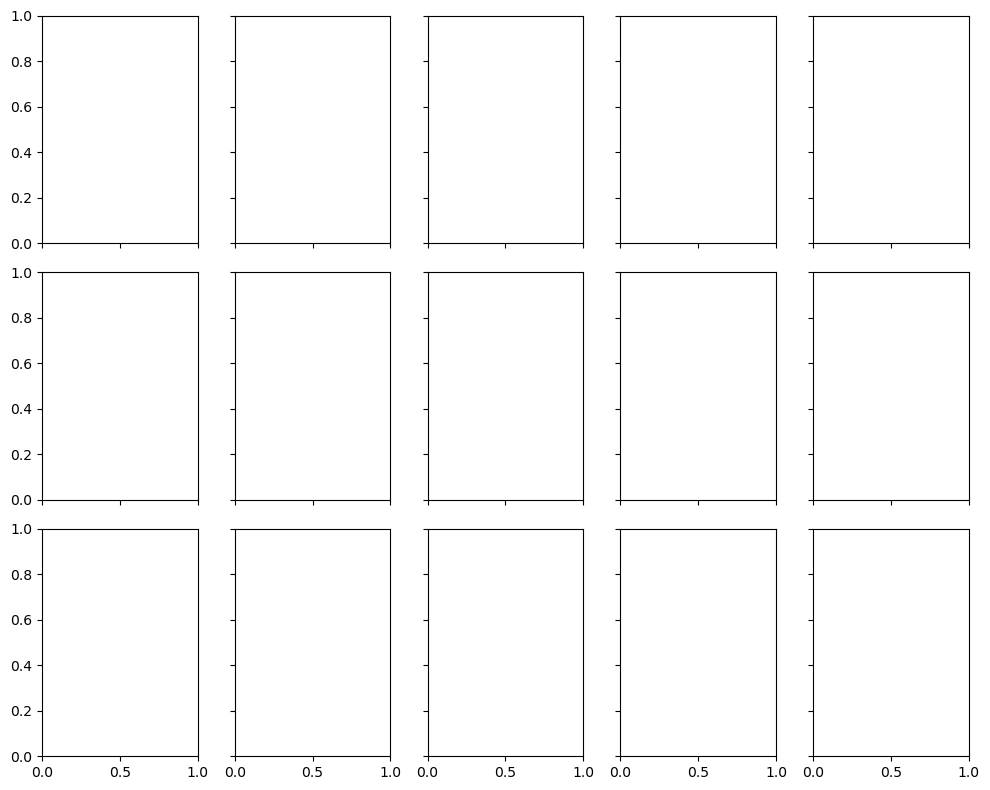

In [4]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a[i]*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

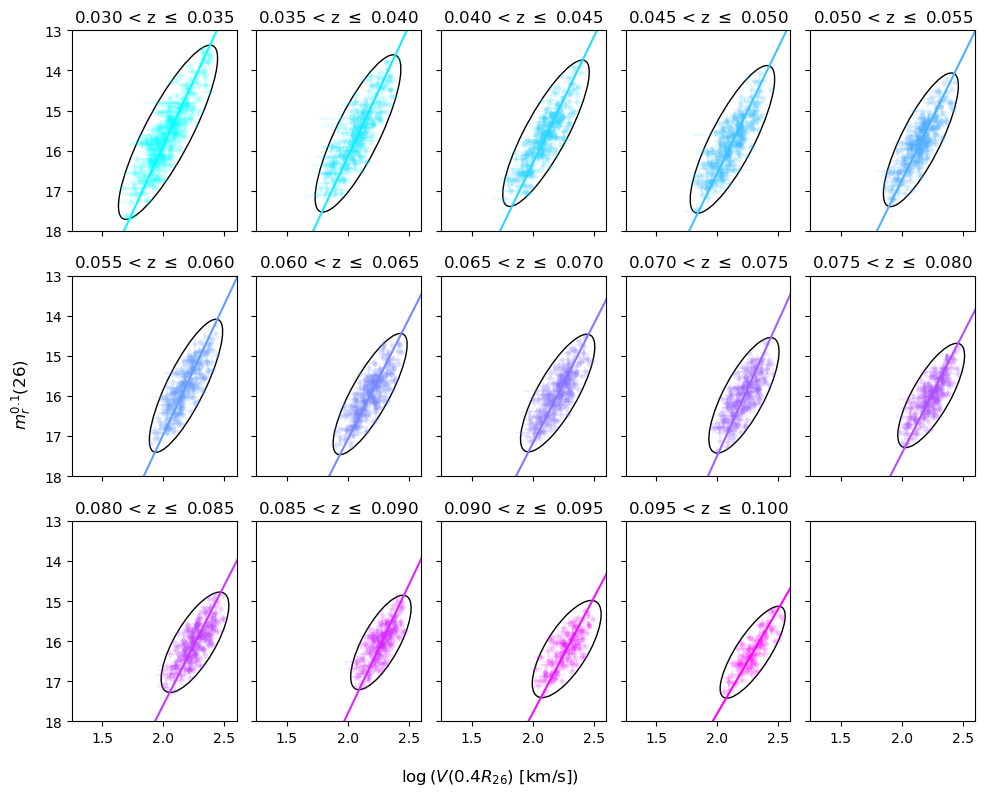

In [59]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a[i]*_logv + b_[i], color=c)
    plot_ellipse(mean=(mu_x[i], mu_y[i]), cov = ([cov_xx[i], cov_xy[i]],[cov_yx[i], cov_yy[i]]),
                 n_std = sigma, ax=axs[row,col], edgecolor='k', facecolor='none')
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

# Calculate logdistance ratios

In [60]:
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)
# cosmo = DESI()

sgatab['MU_ZCMB'] = cosmo.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

In [61]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(sgatab['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(sgatab['Z_DESI_CMB'][i]), 
                               sgatab['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

sgatab['MU_ZCMB_ERR'] = mu_err

sgatab['R_ABSMAG_SB26_ERR'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['MU_ZCMB_ERR'].value**2)

100%|██████████| 10200/10200 [00:12<00:00, 793.36it/s]


In [62]:
# Center redshift values of each bin
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax, dz)
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmo.distmod(zc)

In [104]:
slope = a
slope_err = np.sqrt([cov[0,0] for cov in cov_tfr])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
ZP = b - mu_zc.value
ZP_err = np.sqrt([cov[1,1] for cov in cov_tfr]) # Should include z-bin width to this uncertainty

sig = sig_tfr

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
absmag = slope*(logv - logV0) + ZP

In [105]:
spiral_boolean = sgatab['MORPHTYPE_AI'] == 'Spiral'
irregular_boolean = sgatab['MORPHTYPE_AI'] == 'Irregular'
# other_boolean = sgatab['MORPHTYPE_AI'] == 'Other'

VI_boolean = sgatab['JOHN_VI'].mask

morph_boolean = (spiral_boolean | irregular_boolean) & VI_boolean

In [106]:
sgatab['GOOD_MORPH'] = morph_boolean

print(sum(outlier_boolean), 'outliers')
print(sum(~outlier_boolean), 'non-outliers')
print('-----------')
print(np.sum(morph_boolean), 'spirals & irregulars that pass VI')
print(np.sum(morph_boolean & outlier_boolean), 'outliers')
print(np.sum(morph_boolean & ~outlier_boolean), 'non-outliers')

1273 outliers
8927 non-outliers
-----------
9212 spirals & irregulars that pass VI
1039 outliers
8173 non-outliers


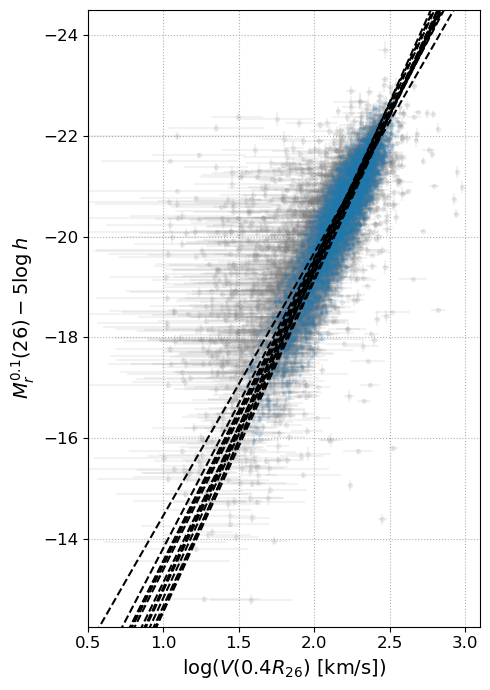

In [124]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample], 
             xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
             yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean# & morph_boolean
plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample], 
             xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
             yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             color='tab:blue',
             alpha=0.1, 
             ecolor='gray')

# sample = ~outlier_boolean_alt & outlier_boolean
# plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
#              sgatab['R_ABSMAG_SB26'][sample], 
#              xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
#              yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
#              fmt='.', 
#              markersize=4, 
#              alpha=0.2, 
#              ecolor='gray')



plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

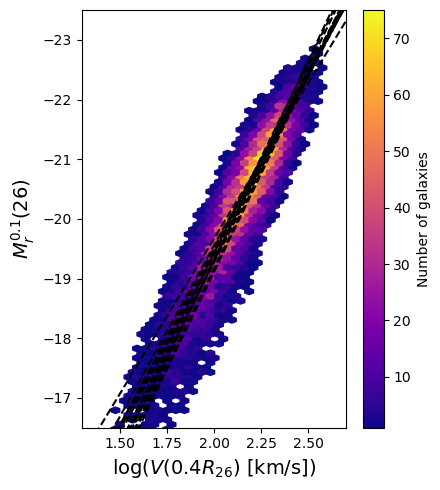

In [108]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hexbin(np.log10(sgatab['V_0p4R26'][~outlier_boolean]), 
           sgatab['R_ABSMAG_SB26'][~outlier_boolean], 
           cmap='plasma', 
           mincnt=1, 
           gridsize=(70,80), 
           extent=(-0.1, 3.1, -25, -12.25))
plt.colorbar(label='Number of galaxies')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([1.3, 2.7])
plt.ylim([-16.5, -23.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

#### Redshift distribution

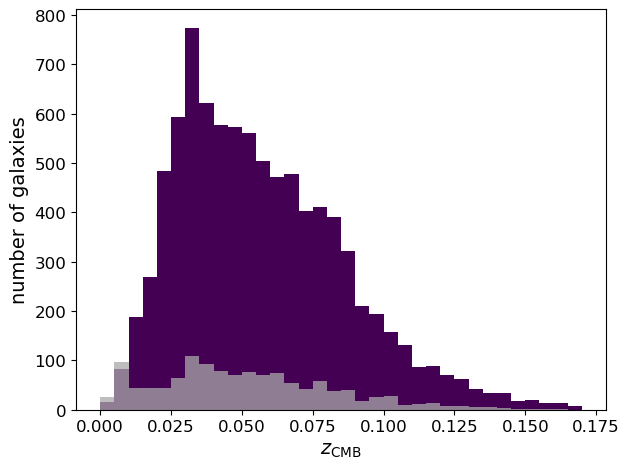

In [109]:
plt.figure(tight_layout=True)

plt.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
         bins=np.arange(0, 0.175, 0.005))
plt.hist(sgatab['Z_DESI_CMB'][outlier_boolean],
         bins=np.arange(0, 0.175, 0.005), 
         color='darkgray',
         alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# Distance moduli

In [111]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(sgatab['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
sgatab['R_ABSMAG_SB26_TF'] = np.nan
for i in range(len(sgatab)):
    sgatab['R_ABSMAG_SB26_TF'][i] = slope[zbin_indices[i] - 1]*(np.log10(sgatab['V_0p4R26'][i]) - logV0) + ZP[zbin_indices[i] - 1]

In [112]:
sgatab['R_ABSMAG_SB26_TF_ERR'] = np.nan
sgatab['R_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(sgatab))):
    
    v_random = rng.normal(sgatab['V_0p4R26'][i], 
                          sgatab['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(sgatab['V_0p4R26'][i]), 
    #                          0.434*sgatab['V_0p4R26_ERR'][i]/sgatab['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = slope[zbin_indices[i] - 1]*(np.log10(v_random[v_random > 0]) - logV0) + ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # sgatab['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    sgatab['R_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + sig[zbin_indices[i] - 1]**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
sgatab['R_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR']**2 - sgatab['R_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████| 10200/10200 [00:04<00:00, 2183.23it/s]


In [113]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

/tmp/ipykernel_535926/3818747994.py:50: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt((mean2 - mean**2) / (N - 1))


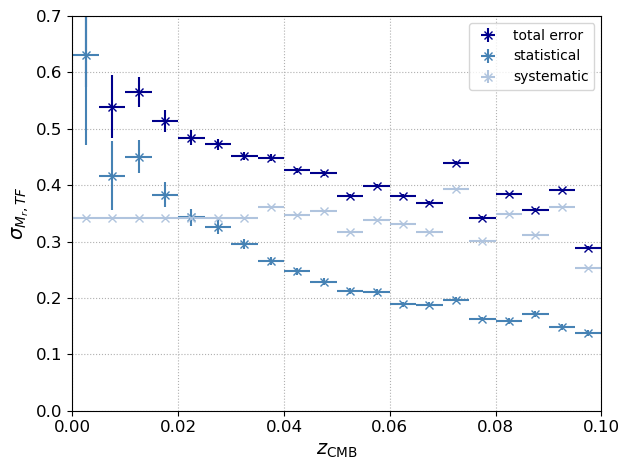

In [114]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

plt.figure(tight_layout=True)

# plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# Total uncertainty
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.1)
plt.ylim(0, 0.7)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

## Compute distance modulus based on our TFR

In [115]:
sgatab['MU_TF'] = sgatab['R_MAG_SB26_CORR'] - sgatab['R_ABSMAG_SB26_TF']

sgatab['MU_TF_ERR'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['R_ABSMAG_SB26_TF_ERR']**2)

## $\Delta M_r$ v. redshift

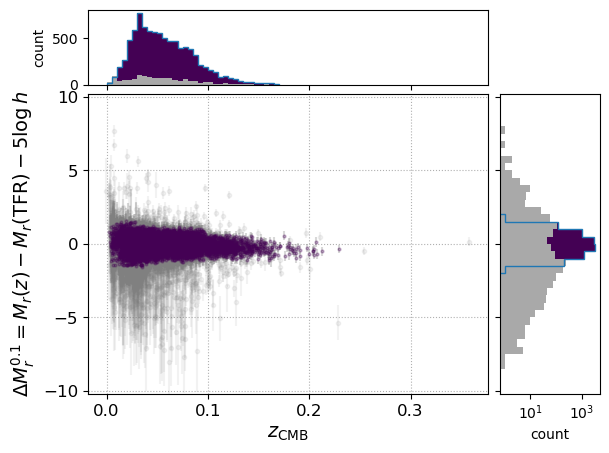

In [116]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

sample = outlier_boolean# & morph_boolean
ax.errorbar(sgatab['Z_DESI_CMB'][sample], 
             sgatab['R_ABSMAG_SB26'][sample] - sgatab['R_ABSMAG_SB26_TF'][sample], 
             xerr=sgatab['ZERR_DESI'][sample], 
             yerr=sgatab['MU_TF_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean
ax.errorbar(sgatab['Z_DESI_CMB'][sample], 
             sgatab['R_ABSMAG_SB26'][sample] - sgatab['R_ABSMAG_SB26_TF'][sample], 
             xerr=sgatab['ZERR_DESI'][sample], 
             yerr=sgatab['MU_TF_ERR'][sample],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\Delta M_r^{0.1} = M_r(z) - M_r(\text{TFR}) - 5\log h$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(sgatab['Z_DESI_CMB'][outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
sample1 = ~outlier_boolean
sample2 = outlier_boolean
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample1] - sgatab['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample2] - sgatab['R_ABSMAG_SB26_TF'][sample2], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample1] - sgatab['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

## $\eta$ v. redshift

In [117]:
sgatab['LOGDIST'] = 0.2*(sgatab['MU_ZCMB'] - sgatab['MU_TF'])
sgatab['LOGDIST_ERR'] = 0.2*np.sqrt(sgatab['MU_ZCMB_ERR']**2 + sgatab['MU_TF_ERR']**2)

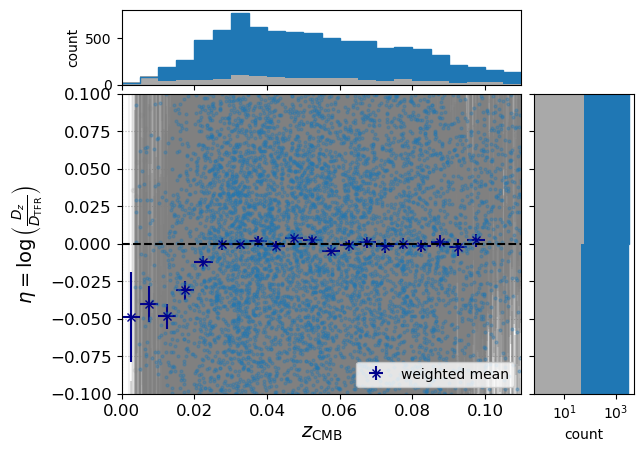

In [118]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(sgatab['Z_DESI_CMB'][sample2], 
             sgatab['LOGDIST'][sample2], 
             xerr=sgatab['ZERR_DESI'][sample2], 
             yerr=sgatab['LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

ax.errorbar(sgatab['Z_DESI_CMB'][sample1], 
             sgatab['LOGDIST'][sample1], 
             xerr=sgatab['ZERR_DESI'][sample1], 
             yerr=sgatab['LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3,
             color='tab:blue',
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=sgatab['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              color='tab:blue',
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(sgatab['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1),
              color='tab:blue',
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

In [120]:
# Create a single column to denote which objects should be used for cosmological analysis
sgatab['OUTLIER'] = outlier_boolean
sgatab['MAIN'] = ~sgatab['OUTLIER'] & sgatab['GOOD_MORPH']

In [122]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['V_RADIUS'] = '0.4 R26'
# hdr['M'] = slope
# hdr['M_ERR'] = slope_err
# hdr['0PT'] = ZP
# hdr['0PT_ERR'] = ZP_err
hdr['logV0'] = logV0
# hdr['SIG'] = np.median(tfr_mcmc_samples[-1])
# hdr['SIG_ERR'] = np.sqrt(cov_tfr[-1,-1])
hdr['H0'] = H0

hdr['EL_STD'] = sigma

# hdr['EL_MU_X'] = ellipse_mean[0]
# hdr['EL_MU_Y'] = ellipse_mean[1]

# # Ellipse covariance matrix
# hdr['EL_COV00'] = ellipse_cov[0, 0]
# hdr['EL_COV01'] = ellipse_cov[0, 1]
# hdr['EL_COV10'] = ellipse_cov[1, 0]
# hdr['EL_COV11'] = ellipse_cov[1, 1]


empty_primary = fits.PrimaryHDU(header=hdr)

In [123]:
table_hdu = fits.BinTableHDU(data=sgatab)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('/global/homes/s/sgmoore1/DESI_SGA/TF/Y1/systematic_tests/SGA_iron_jointTFR_v9.fits', 
             overwrite=True)

In [125]:
# hdul.writeto('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/systematic_tests/DESI-DR1_TF_pv_test_cat_v9.fits', 
#              overwrite=True)

In [101]:
# tab = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/systematic_tests/DESI-DR1_TF_pv_test_cat_v5.fits')
# hdr = tab.meta

In [ ]:
# SGA_TF = Table.read('SGA_iron_jointTFR_v5.fits')

In [ ]:
# ba_bins = np.arange(0, 1, 0.05)
# dba = 0.5*np.diff(ba_bins)
# bac = 0.5*(ba_bins[1:] + ba_bins[:-1])

# plt.figure(tight_layout=True, dpi=150)

# plt.grid(ls=':')

# sample = SGA_TF['MAIN']

# # Plot weighted mean
# _, y_avg, y_std = profile_histogram(SGA_TF['BA'][sample], 
#                                     SGA_TF['LOGDIST'][sample], 
#                                     ba_bins, 
#                                     weights=SGA_TF['LOGDIST_ERR'][sample]**-2, 
#                                     weighted=True)
# plt.errorbar(bac, y_avg, xerr=dba, yerr=y_std, fmt='x', color='darkblue', label='unweighted mean')

# plt.hlines(0, 0, 1, linestyles='dashed', colors='k', zorder=10)

# plt.xlim(0, 1)
# plt.ylim(-0.1, 0.1)

# plt.xlabel('$b/a$')
# plt.ylabel('$\eta$');